<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/BIKE_DEMAND_SONIA_ahead24h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional
import seaborn as sns

In [176]:
data = pd.read_csv('/content/london_merged.csv')

In [177]:
data.cnt.std()

1085.1080679362167

In [4]:
target = 'cnt'
features = [i for i in data.columns if i not in [target]]

print("Target:", target)
print("Variables de contexto:", features)

Target: cnt
Variables de contexto: ['timestamp', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']


In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')

In [121]:
'''
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp")
'''
data['hour'] = data.index.hour #horas
data["day_of_week"] = data.index.weekday
data["day_of_month"] = data.index.day
data["month"] = data.index.month
data["year"] = data.index.year


#timestamp
target = data['cnt'].values
t1 = data['t1'].values
t2 = data['t2'].values
hum = data['hum'].values
viento = data['wind_speed'].values
tiempo = data['weather_code'].values
festivo = data['is_holiday'].values
#is_weekend
#season
#year
mes = data['month'].values
dia = data['day_of_week'].values
hora = data['hour'].values

AttributeError: ignored

In [7]:
estacion = data['season'].values
festivo = data['is_holiday'].values
timestamp = data["timestamp"].values
year_month = data["year_month"].values

In [11]:
data["year_month"] = data.index.strftime('%Y-%m')
year_month = data["year_month"].values

In [20]:
data = data.reset_index()

In [21]:
timestamp = data["timestamp"].values

In [12]:
data.head(5)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month,year,year_month
timestamp,,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1,2015,2015-01
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1,2015,2015-01
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1,2015,2015-01
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1,2015,2015-01
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1,2015,2015-01


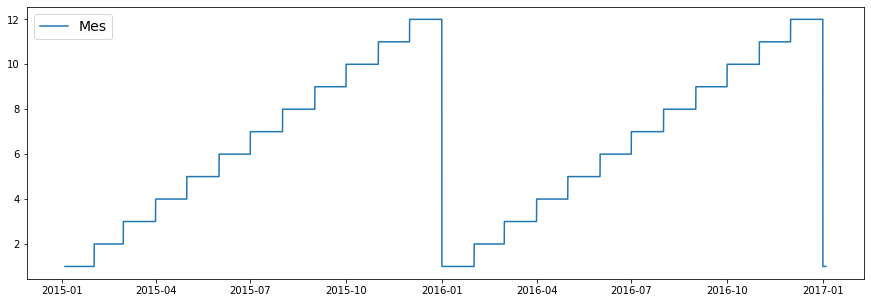

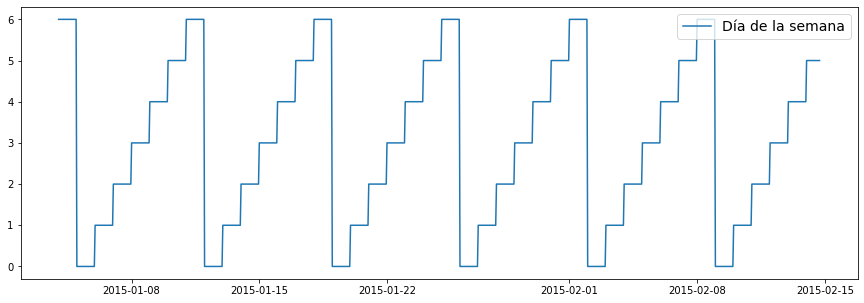

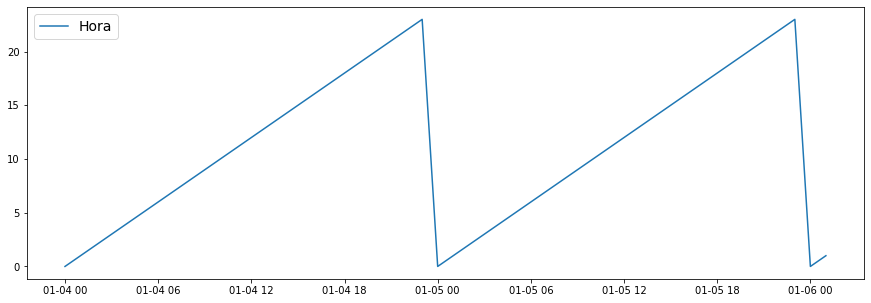

In [33]:
plt.figure(figsize=(15,5))
plt.plot(timestamp, mes, label='Mes')
plt.legend(fontsize=14);
plt.figure(figsize=(15,5))
plt.plot(timestamp[:1000], dia[:1000], label='Día de la semana')
plt.legend(fontsize=14);
plt.figure(figsize=(15,5))
plt.plot(timestamp[0:50], hora[0:50], label='Hora')
plt.legend(fontsize=14);

In [34]:
def encode_ciclicas(v, n_valores):
    x = np.cos(v/n_valores * 2*np.pi)
    y = np.sin(v/n_valores * 2*np.pi)
    return x, y

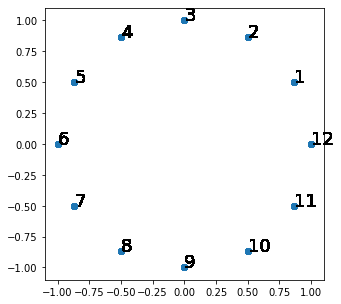

In [35]:
coords_x_mes, coords_y_mes = encode_ciclicas(mes, 12)
plt.figure(figsize=(5,5))
plt.plot(coords_x_mes, coords_y_mes, "o")
for cx,cy,texto in zip(coords_x_mes, coords_y_mes, mes):
    plt.text(cx,cy,texto, fontsize=18)

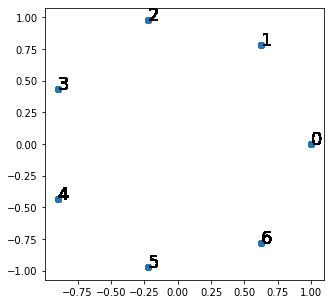

In [37]:
coords_x_day_of_week, coords_y_day_of_week = encode_ciclicas(dia, 7)
plt.figure(figsize=(5,5))
plt.plot(coords_x_day_of_week, coords_y_day_of_week, "o")
for cx,cy,texto in zip(coords_x_day_of_week, coords_y_day_of_week, dia):
    plt.text(cx,cy,texto, fontsize=18)

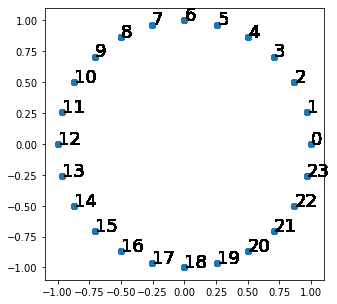

In [40]:
coords_x_hora, coords_y_hora = encode_ciclicas(hora, 24)
plt.figure(figsize=(5,5))
plt.plot(coords_x_hora, coords_y_hora, "o")
for cx,cy,texto in zip(coords_x_hora, coords_y_hora, hora):
    plt.text(cx,cy,texto, fontsize=18)

In [ ]:

from sklearn.preprocessing import RobustScaler
f_columns = ['t1', 'hum', 'wind_speed']
f_transformer = RobustScaler()
f_transformer = f_transformer.fit(data[f_columns].to_numpy())
data.loc[:, f_columns] = f_transformer.transform(data[f_columns].to_numpy())

In [175]:
data.cnt.std()

1.0000000000000056

In [46]:
# Transformación de escala (ajustar el factor en función del problema)
def transform(x):
    return x/data.cnt.std()
def inverse_transform(x_escalado):
    return x_escalado*1085.10 #data.cnt.std()

In [178]:
def inverse_transform(x_escalado):
    return x_escalado*1085.10 #data.cnt.std()

In [47]:
data['cnt'] = transform(data['cnt'])

In [49]:
data['cnt'].max()

7.243518164000984

In [48]:
data.head(5)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month,year,year_month
0,2015-01-04 00:00:00,0.167725,-1.1875,2.0,0.925,-0.857143,3.0,0.0,1.0,3.0,0,6,4,1,2015,2015-01
1,2015-01-04 01:00:00,0.127176,-1.1875,2.5,0.925,-0.952381,1.0,0.0,1.0,3.0,1,6,4,1,2015,2015-01
2,2015-01-04 02:00:00,0.123490,-1.2500,2.5,1.100,-1.428571,1.0,0.0,1.0,3.0,2,6,4,1,2015,2015-01
3,2015-01-04 03:00:00,0.066353,-1.3125,2.0,1.275,-1.428571,1.0,0.0,1.0,3.0,3,6,4,1,2015,2015-01
4,2015-01-04 04:00:00,0.043314,-1.3125,0.0,0.925,-0.809524,1.0,0.0,1.0,3.0,4,6,4,1,2015,2015-01


In [123]:
target = data['cnt'].values
t1 = data['t1'].values
t2 = data['t2'].values
hum = data['hum'].values
viento = data['wind_speed'].values
tiempo = data['weather_code'].values
festivo = data['is_holiday'].values
#is_weekend
#season
#year
mes = data['month'].values
dia = data['day_of_week'].values
hora = data['hour'].values

estacion = data['season'].values
festivo = data['is_holiday'].values
timestamp = data["timestamp"].values
year_month = data["year_month"].values

In [ ]:
cnt	t1	t2	hum	wind_speed	weather_code	is_holiday	is_weekend	season	hour	day_of_week	day_of_month	month	year	year_month

In [124]:
target_transf = transform(target)

series = [target_transf, t1, hum, viento, festivo]
se_saben_antes = [False, True, True, True, True]
nombres_series = ["target_transf", "t1", "hum", "wind_speed", "is_holiday"]

# Variables calendario sobre las que hemos la transformación cíclica
series.append(coords_x_mes)
nombres_series.append("coords_x_mes")
se_saben_antes.append(True)

series.append(coords_y_mes)
nombres_series.append("coords_y_mes")
se_saben_antes.append(True)

series.append(coords_x_hora)
nombres_series.append("coords_x_semana")
se_saben_antes.append(True)

series.append(coords_y_hora)
nombres_series.append("coords_y_hora")
se_saben_antes.append(True)

series.append(coords_x_day_of_week)
nombres_series.append("coords_x_dia")
se_saben_antes.append(True)

series.append(coords_y_day_of_week)
nombres_series.append("coords_y_dia")
se_saben_antes.append(True)

In [125]:
print(np.shape(series))
print(np.shape(se_saben_antes))

(11, 17414)
(11,)


In [126]:
series

[array([0.16772523, 0.12717627, 0.12349   , ..., 0.31056815, 0.20643105,
        0.12809784]),
 array([-1.1875, -1.1875, -1.25  , ..., -0.875 , -0.875 , -0.9375]),
 array([0.925, 0.925, 1.1  , ..., 0.2  , 0.075, 0.075]),
 array([-0.85714286, -0.95238095, -1.42857143, ...,  0.85714286,
         0.76190476,  0.66666667]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.8660254, 0.8660254, 0.8660254, ..., 0.8660254, 0.8660254,
        0.8660254]),
 array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]),
 array([1.        , 0.96592583, 0.8660254 , ..., 0.70710678, 0.8660254 ,
        0.96592583]),
 array([ 0.        ,  0.25881905,  0.5       , ..., -0.70710678,
        -0.5       , -0.25881905]),
 array([0.6234898, 0.6234898, 0.6234898, ..., 0.6234898, 0.6234898,
        0.6234898]),
 array([-0.78183148, -0.78183148, -0.78183148, ...,  0.78183148,
         0.78183148,  0.78183148])]

In [55]:
from my_utils_series_temporales import NAN, int2dummy, enventanar, info_enventanado

In [127]:
lookback = 48 # lookback es otro sinónimo de W_in (LAG)
time_step = 24 # valores a predecir (N_AHEAD, N_OUTPUTS)

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback, W_out = time_step)

print(X.shape, np.shape(y))

(17414, 48, 11) (17414, 24)


In [128]:
print(X.shape)
print(np.shape(target))

(17414, 48, 11)
(17414,)


In [129]:
info_enventanado(X[:10],y[:10],
                 nombres_series=nombres_series,
                 nombre_target="target",
                 tiempos=timestamp)

10 ventanas creadas

X.shape=(10, 48, 11)  Y.shape=(10, 24) 

 Ventana 0: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,?27,?28,?29,?30,?31,?32,?33,?34,?35,?36,?37,?38,?39,?40,?41,?42,?43,?44,?45,?46,?47
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
t1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.187500
hum,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.925000
wind_speed,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.857143
is_holiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000
coords_x_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.866025
coords_y_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.500000
coords_x_semana,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000
coords_y_hora,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000
coords_x_dia,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.623490


 Ventana 1: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,?27,?28,?29,?30,?31,?32,?33,?34,?35,?36,?37,?38,?39,?40,?41,?42,?43,?44,?45,?46,2015-01-04T00:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.167725
t1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.187500,-1.187500
hum,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.925000,0.925000
wind_speed,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.857143,-0.952381
is_holiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000
coords_x_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.866025,0.866025
coords_y_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.500000,0.500000
coords_x_semana,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.965926
coords_y_hora,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.258819
coords_x_dia,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.623490,0.623490


 Ventana 2: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,?27,?28,?29,?30,?31,?32,?33,?34,?35,?36,?37,?38,?39,?40,?41,?42,?43,?44,?45,2015-01-04T00:00:00.000000000,2015-01-04T01:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.167725,0.127176
t1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.187500,-1.187500,-1.250000
hum,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.925000,0.925000,1.100000
wind_speed,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.857143,-0.952381,-1.428571
is_holiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000
coords_x_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.866025,0.866025,0.866025
coords_y_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.500000,0.500000,0.500000
coords_x_semana,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.965926,0.866025
coords_y_hora,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.258819,0.500000
coords_x_dia,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.623490,0.623490,0.623490


 Ventana 3: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,?27,?28,?29,?30,?31,?32,?33,?34,?35,?36,?37,?38,?39,?40,?41,?42,?43,?44,2015-01-04T00:00:00.000000000,2015-01-04T01:00:00.000000000,2015-01-04T02:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.167725,0.127176,0.123490
t1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.187500,-1.187500,-1.250000,-1.312500
hum,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.925000,0.925000,1.100000,1.275000
wind_speed,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.857143,-0.952381,-1.428571,-1.428571
is_holiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000
coords_x_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.866025,0.866025,0.866025,0.866025
coords_y_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.500000,0.500000,0.500000,0.500000
coords_x_semana,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.965926,0.866025,0.707107
coords_y_hora,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.258819,0.500000,0.707107
coords_x_dia,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.623490,0.623490,0.623490,0.623490


 Ventana 4: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,?27,?28,?29,?30,?31,?32,?33,?34,?35,?36,?37,?38,?39,?40,?41,?42,?43,2015-01-04T00:00:00.000000000,2015-01-04T01:00:00.000000000,2015-01-04T02:00:00.000000000,2015-01-04T03:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.167725,0.127176,0.123490,0.066353
t1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.187500,-1.187500,-1.250000,-1.312500,-1.312500
hum,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.925000,0.925000,1.100000,1.275000,0.925000
wind_speed,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.857143,-0.952381,-1.428571,-1.428571,-0.809524
is_holiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000
coords_x_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.866025,0.866025,0.866025,0.866025,0.866025
coords_y_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.500000,0.500000,0.500000,0.500000,0.500000
coords_x_semana,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.965926,0.866025,0.707107,0.500000
coords_y_hora,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.258819,0.500000,0.707107,0.866025
coords_x_dia,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.623490,0.623490,0.623490,0.623490,0.623490


 Ventana 5: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,?27,?28,?29,?30,?31,?32,?33,?34,?35,?36,?37,?38,?39,?40,?41,?42,2015-01-04T00:00:00.000000000,2015-01-04T01:00:00.000000000,2015-01-04T02:00:00.000000000,2015-01-04T03:00:00.000000000,2015-01-04T04:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.167725,0.127176,0.123490,0.066353,0.043314
t1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.187500,-1.187500,-1.250000,-1.312500,-1.312500,-1.312500
hum,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.925000,0.925000,1.100000,1.275000,0.925000,0.925000
wind_speed,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.857143,-0.952381,-1.428571,-1.428571,-0.809524,-1.047619
is_holiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
coords_x_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025
coords_y_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
coords_x_semana,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.965926,0.866025,0.707107,0.500000,0.258819
coords_y_hora,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.258819,0.500000,0.707107,0.866025,0.965926
coords_x_dia,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490


 Ventana 6: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,?27,?28,?29,?30,?31,?32,?33,?34,?35,?36,?37,?38,?39,?40,?41,2015-01-04T00:00:00.000000000,2015-01-04T01:00:00.000000000,2015-01-04T02:00:00.000000000,2015-01-04T03:00:00.000000000,2015-01-04T04:00:00.000000000,2015-01-04T05:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.167725,0.127176,0.123490,0.066353,0.043314,0.042392
t1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.187500,-1.187500,-1.250000,-1.312500,-1.312500,-1.312500,-1.437500
hum,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.925000,0.925000,1.100000,1.275000,0.925000,0.925000,1.275000
wind_speed,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.857143,-0.952381,-1.428571,-1.428571,-0.809524,-1.047619,-0.761905
is_holiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
coords_x_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025
coords_y_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
coords_x_semana,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.965926,0.866025,0.707107,0.500000,0.258819,0.000000
coords_y_hora,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.258819,0.500000,0.707107,0.866025,0.965926,1.000000
coords_x_dia,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490


 Ventana 7: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,?27,?28,?29,?30,?31,?32,?33,?34,?35,?36,?37,?38,?39,?40,2015-01-04T00:00:00.000000000,2015-01-04T01:00:00.000000000,2015-01-04T02:00:00.000000000,2015-01-04T03:00:00.000000000,2015-01-04T04:00:00.000000000,2015-01-04T05:00:00.000000000,2015-01-04T06:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.167725,0.127176,0.123490,0.066353,0.043314,0.042392,0.047000
t1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.187500,-1.187500,-1.250000,-1.312500,-1.312500,-1.312500,-1.437500,-1.437500
hum,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.925000,0.925000,1.100000,1.275000,0.925000,0.925000,1.275000,1.275000
wind_speed,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.857143,-0.952381,-1.428571,-1.428571,-0.809524,-1.047619,-0.761905,-0.761905
is_holiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
coords_x_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025
coords_y_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
coords_x_semana,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.965926,0.866025,0.707107,0.500000,0.258819,0.000000,-0.258819
coords_y_hora,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.258819,0.500000,0.707107,0.866025,0.965926,1.000000,0.965926
coords_x_dia,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490


 Ventana 8: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,?27,?28,?29,?30,?31,?32,?33,?34,?35,?36,?37,?38,?39,2015-01-04T00:00:00.000000000,2015-01-04T01:00:00.000000000,2015-01-04T02:00:00.000000000,2015-01-04T03:00:00.000000000,2015-01-04T04:00:00.000000000,2015-01-04T05:00:00.000000000,2015-01-04T06:00:00.000000000,2015-01-04T07:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.167725,0.127176,0.123490,0.066353,0.043314,0.042392,0.047000,0.069118
t1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.187500,-1.187500,-1.250000,-1.312500,-1.312500,-1.312500,-1.437500,-1.437500,-1.375000
hum,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.925000,0.925000,1.100000,1.275000,0.925000,0.925000,1.275000,1.275000,1.100000
wind_speed,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.857143,-0.952381,-1.428571,-1.428571,-0.809524,-1.047619,-0.761905,-0.761905,-0.666667
is_holiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
coords_x_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025
coords_y_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
coords_x_semana,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.965926,0.866025,0.707107,0.500000,0.258819,0.000000,-0.258819,-0.500000
coords_y_hora,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.258819,0.500000,0.707107,0.866025,0.965926,1.000000,0.965926,0.866025
coords_x_dia,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490


 Ventana 9: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,?27,?28,?29,?30,?31,?32,?33,?34,?35,?36,?37,?38,2015-01-04T00:00:00.000000000,2015-01-04T01:00:00.000000000,2015-01-04T02:00:00.000000000,2015-01-04T03:00:00.000000000,2015-01-04T04:00:00.000000000,2015-01-04T05:00:00.000000000,2015-01-04T06:00:00.000000000,2015-01-04T07:00:00.000000000,2015-01-04T08:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.167725,0.127176,0.123490,0.066353,0.043314,0.042392,0.047000,0.069118,0.120725
t1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.187500,-1.187500,-1.250000,-1.312500,-1.312500,-1.312500,-1.437500,-1.437500,-1.375000,-1.312500
hum,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.925000,0.925000,1.100000,1.275000,0.925000,0.925000,1.275000,1.275000,1.100000,1.275000
wind_speed,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.857143,-0.952381,-1.428571,-1.428571,-0.809524,-1.047619,-0.761905,-0.761905,-0.666667,-0.571429
is_holiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
coords_x_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025
coords_y_mes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
coords_x_semana,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.965926,0.866025,0.707107,0.500000,0.258819,0.000000,-0.258819,-0.500000,-0.707107
coords_y_hora,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.258819,0.500000,0.707107,0.866025,0.965926,1.000000,0.965926,0.866025,0.707107
coords_x_dia,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490,0.623490


In [74]:
y.shape

(17414, 24)

In [130]:
y2 = y[:-24] #elimino los últimos time_step al tener NAN
X2 = X[:-24]#elimino los últimos time_step al tener NAN
target2 = target[:-24] #elimino los últimos time_step al tener NAN
timestamp2 = timestamp[:-24] #elimino los últimos time_step al tener NAN

In [81]:
print(y2.shape)
print(X2.shape)
print(target2.shape)
print(timestamp2.shape)

(17390, 24)

 Separación training-test

In [131]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)


X_train      = X2[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
y_train      = y2[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
target_train = target2[lookback:punto_corte] # elimino los lookback primeros al tener NANs
fechas_train = timestamp2[lookback:punto_corte] # elimino los lookback primeros al tener NANs

X_test       = X[punto_corte:]
y_test       = y[punto_corte:]
target_test  = target[punto_corte:]
fechas_test  = timestamp2[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(13883,)
(3483,)


In [97]:
len(target_test) + len(target_train)

17366

In [98]:
print(X_train.shape, y_train.shape)

(13883, 48, 11) (13883, 24)


In [99]:
lookback, X_train.shape[-1]

(48, 11)

 Construcción del modelo con Keras

In [132]:
def vanilla_multistep_LSTM():
    model = Sequential()  
    model.add(LSTM(units=50, input_shape=(lookback, X_train.shape[-1])))
    model.add(Dense(time_step))
    return model

In [133]:
loss = 'mean_squared_error'
optimizer = "adam"

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

In [134]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer=optimizer, 
              loss=loss,
              metrics=['mse'])

import keras.backend as K
print(K.get_value(model.optimizer.lr))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                12400     
                                                                 
 dense_4 (Dense)             (None, 24)                1224      
                                                                 
Total params: 13,624
Trainable params: 13,624
Non-trainable params: 0
_________________________________________________________________
0.001


In [136]:
history_model_0 = model.fit(X_train, y_train, epochs=35, validation_split=0.1, batch_size=32)

Epoch 1/35
391/391 [==============================] - 12s 31ms/step - loss: 0.2819 - mse: 0.2819 - val_loss: 0.3331 - val_mse: 0.3331
Epoch 2/35
391/391 [==============================] - 10s 25ms/step - loss: 0.2136 - mse: 0.2136 - val_loss: 0.3016 - val_mse: 0.3016
Epoch 3/35
391/391 [==============================] - 10s 25ms/step - loss: 0.1765 - mse: 0.1765 - val_loss: 0.2493 - val_mse: 0.2493
Epoch 4/35
391/391 [==============================] - 11s 27ms/step - loss: 0.1576 - mse: 0.1576 - val_loss: 0.2245 - val_mse: 0.2245
Epoch 5/35
391/391 [==============================] - 10s 26ms/step - loss: 0.1498 - mse: 0.1498 - val_loss: 0.2316 - val_mse: 0.2316
Epoch 6/35
391/391 [==============================] - 10s 26ms/step - loss: 0.1399 - mse: 0.1399 - val_loss: 0.2113 - val_mse: 0.2113
Epoch 7/35
391/391 [==============================] - 10s 25ms/step - loss: 0.1336 - mse: 0.1336 - val_loss: 0.2144 - val_mse: 0.2144
Epoch 8/35
391/391 [==============================] - 10s 26ms

In [140]:
# Evaluate the model on the test set
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
109/109 [==============================] - 1s 11ms/step - loss: nan - mse: nan 
Test MSE: nan
Test MAE: nan


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

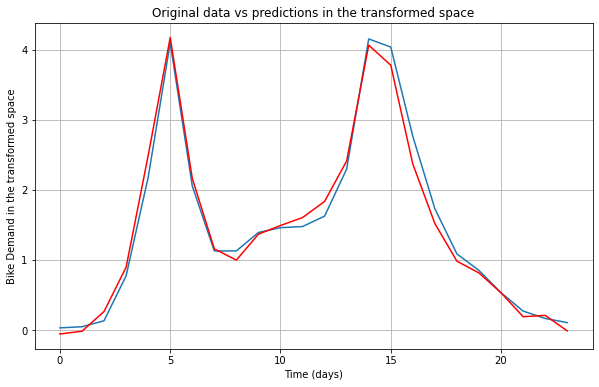

In [145]:
# Prediction
y_pred = model.predict(X_test)

# the_day is the day from which we will study the n_steps_out-th dayS of prediction into 
# the future. Note: The first day start at index 0
the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Bike Demand in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [146]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [147]:
epochs = 25
batch_size = 32
Nval = 200
control_sobreajuste_val = True

if not control_sobreajuste_val:
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=2)
else:    
    acum_tr_mse = []
    acum_val_mse = []
    modelpath="model_current_best.h5"
    checkpoint = ModelCheckpoint(modelpath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    callbacks_list = [checkpoint]
    
    for e in range(epochs):
        #aux = aug.scaling(aug.jitter(X_train[:-Nval])) # data augmentation con jitter
        aux = X_train[:-Nval]
        history = model.fit(aux, y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))
        
        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error
        
        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)


Epoch 1: val_mse improved from inf to 0.11979, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.11979

Epoch 1: val_mse improved from 0.11979 to 0.11491, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.11491 to 0.11277, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not improve from 0.11277

Epoch 1: val_mse did not imp

In [115]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [116]:
model_0 = Sequential()
model_0.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))  # input_shape=[time steps, features]
model_0.add(Dense(100, activation='relu'))
model_0.add(Dense(n_outputs))
model_0.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

In [117]:
model_0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               169600    
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 24)                2424      
                                                                 
Total params: 192,124
Trainable params: 192,124
Non-trainable params: 0
_________________________________________________________________


In [118]:
history_model_0 = model_0.fit(X_train, y_train, epochs=35, validation_split=0.1, batch_size=32)

Epoch 1/35
391/391 [==============================] - 45s 110ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/35
159/391 [===========>..................] - ETA: 23s - loss: nan - mse: nan

KeyboardInterrupt: ignored

probando

Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

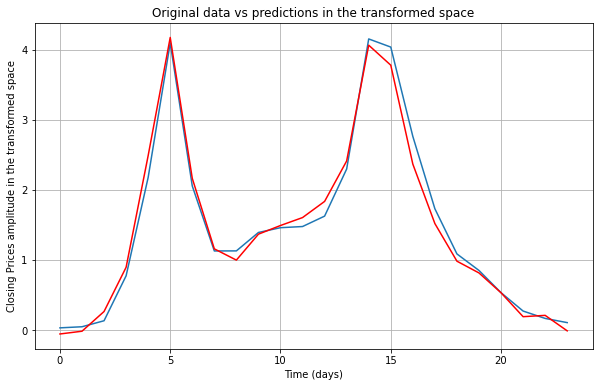

In [141]:
# Prediction
y_pred = model.predict(X_test)

# the_day is the day from which we will study the n_steps_out-th dayS of prediction into 
# the future. Note: The first day start at index 0
the_hour = 0
y_pred_hour = y_pred[the_day,:]


In [206]:
y_pred

array([[-0.05594212, -0.01673202,  0.26441845, ...,  0.19075108,
         0.20941885, -0.01141405],
       [ 0.01078567,  0.19675684,  0.7828093 , ...,  0.12865308,
        -0.02761573, -0.02626342],
       [ 0.15965058,  0.79480594,  2.4489532 , ...,  0.07361817,
         0.20814891,  0.09050679],
       ...,
       [ 0.45599782,  0.38918313,  0.3346392 , ...,  1.9591632 ,
         1.0967755 ,  0.5487582 ],
       [ 0.29884946,  0.22998245,  0.1809567 , ...,  1.0417607 ,
         0.6263505 ,  0.45428747],
       [ 0.22318567,  0.12923798,  0.05836874, ...,  0.66363704,
         0.40307012,  0.17764473]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

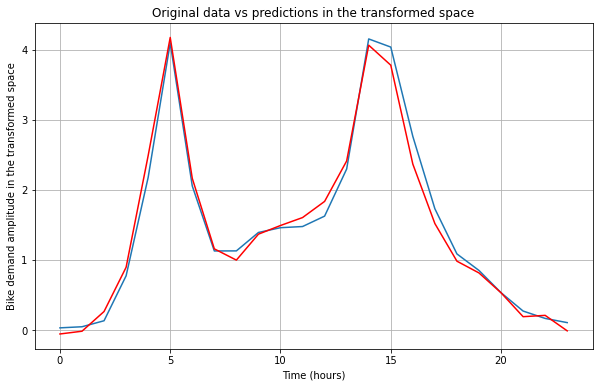

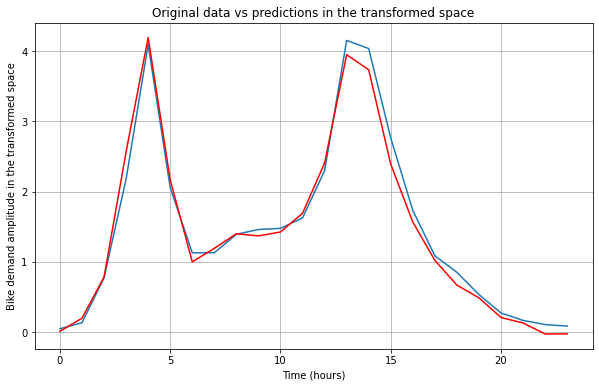

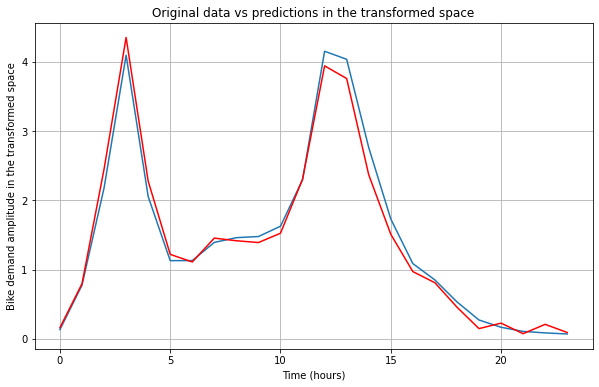

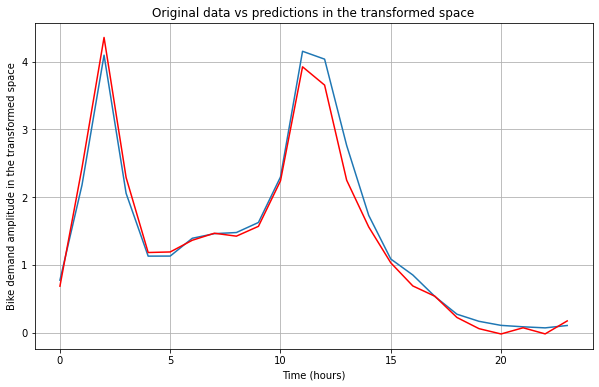

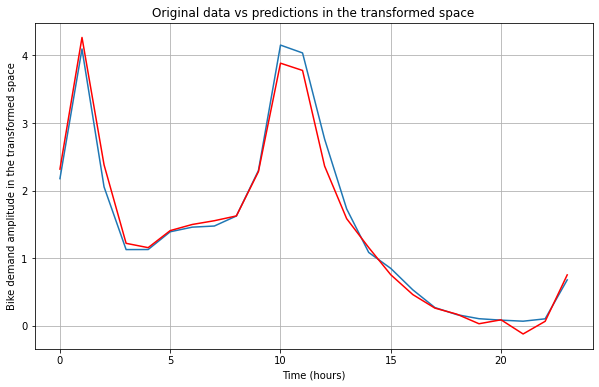

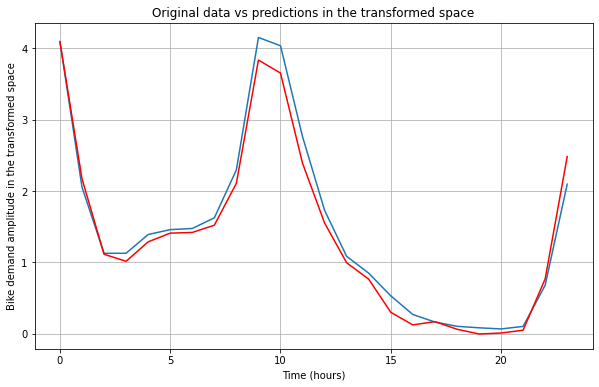

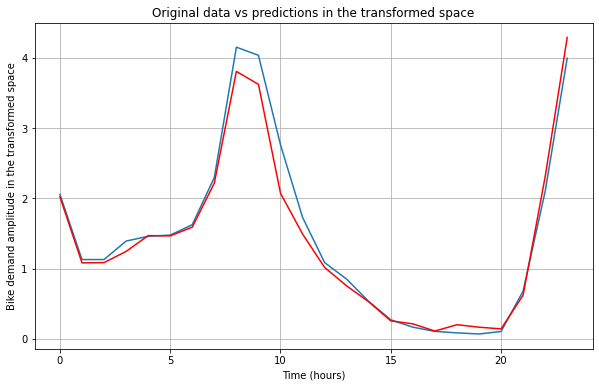

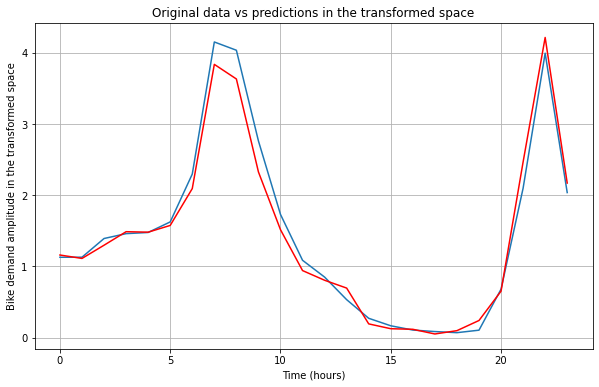

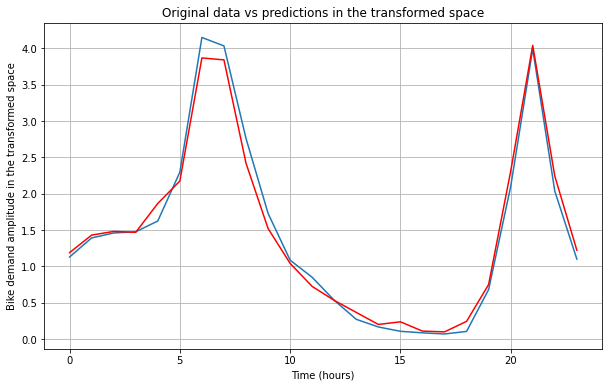

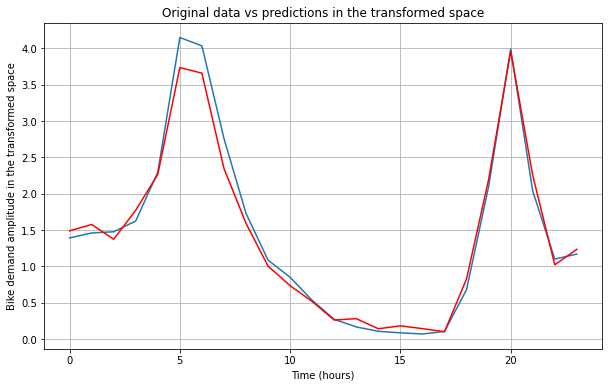

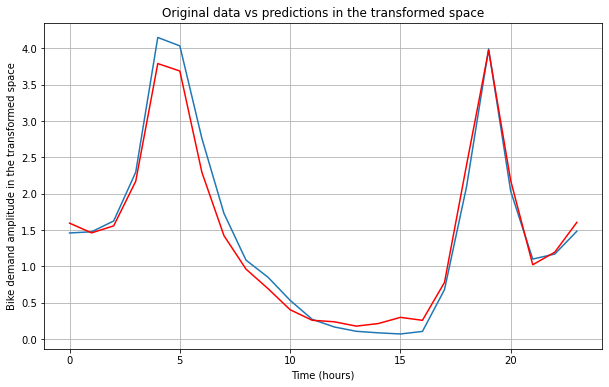

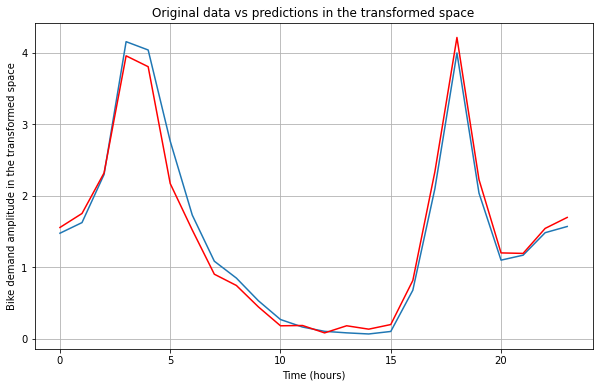

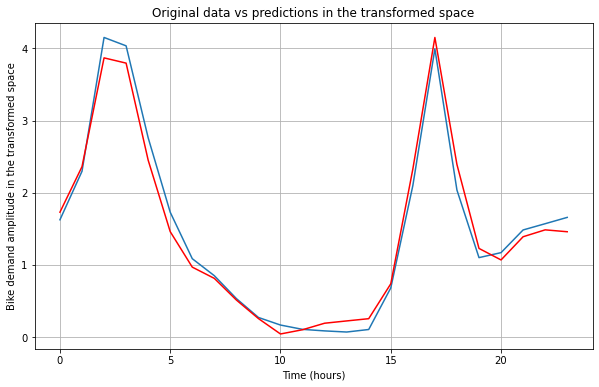

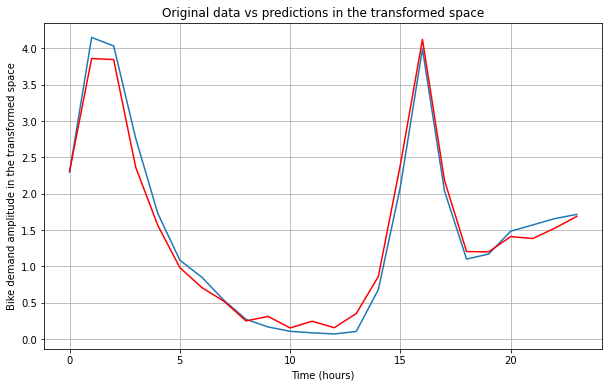

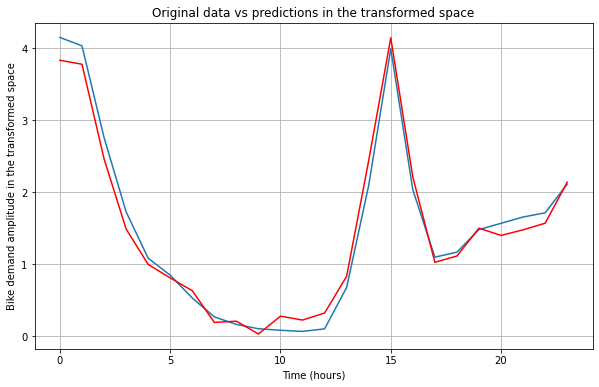

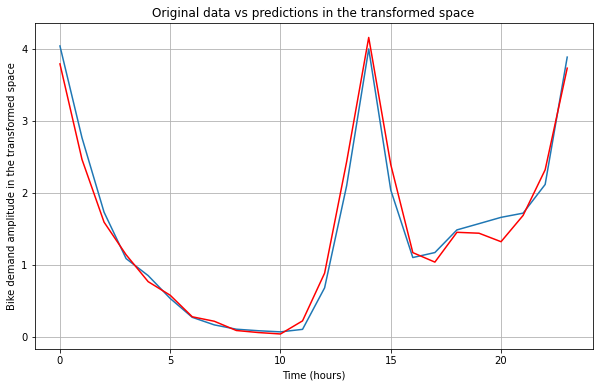

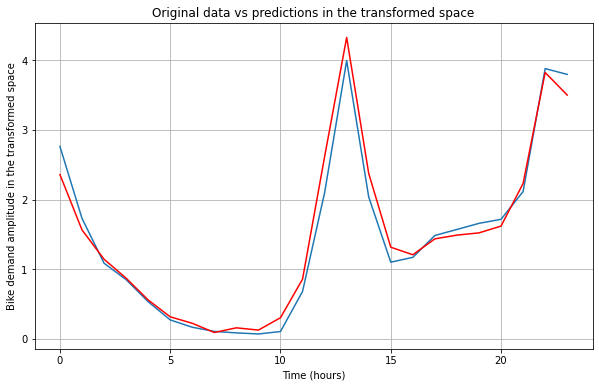

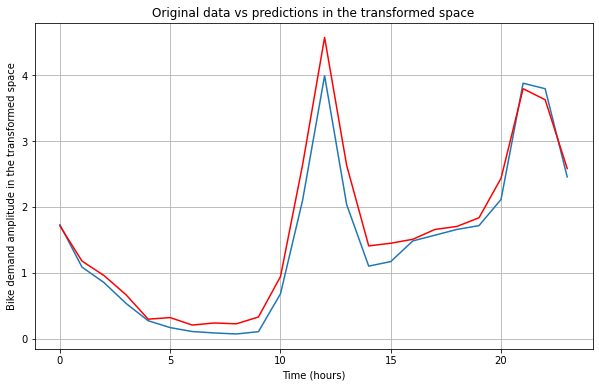

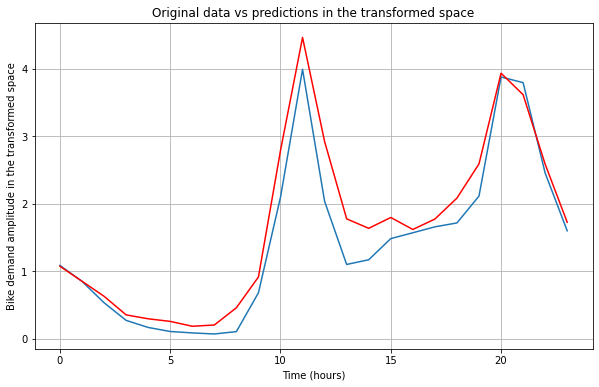

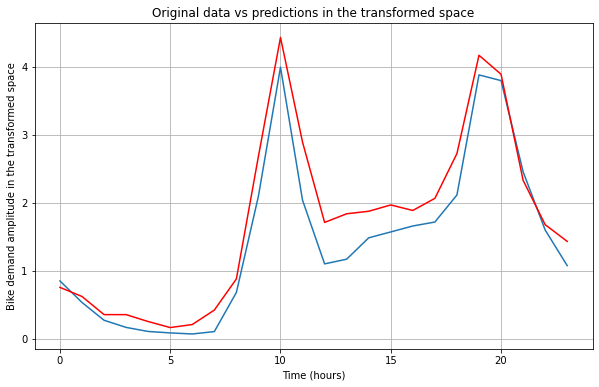

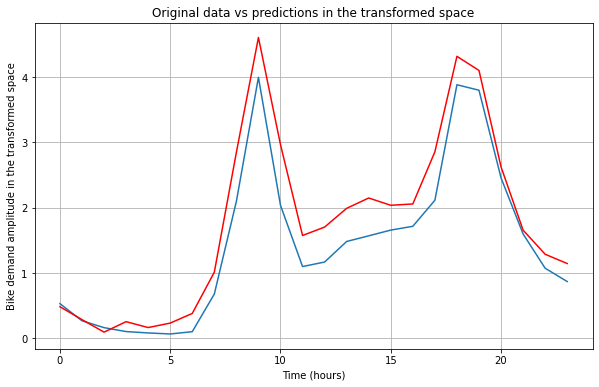

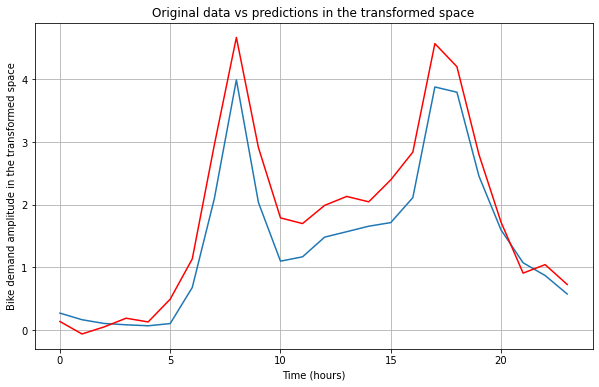

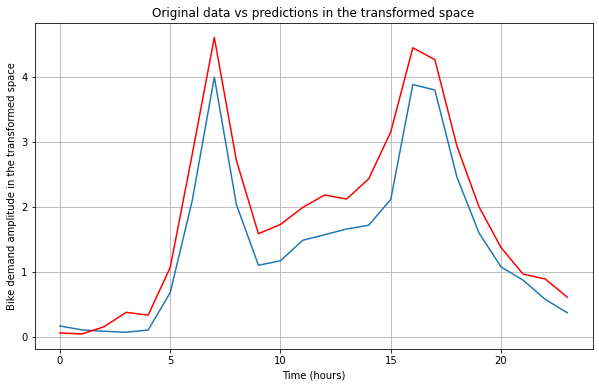

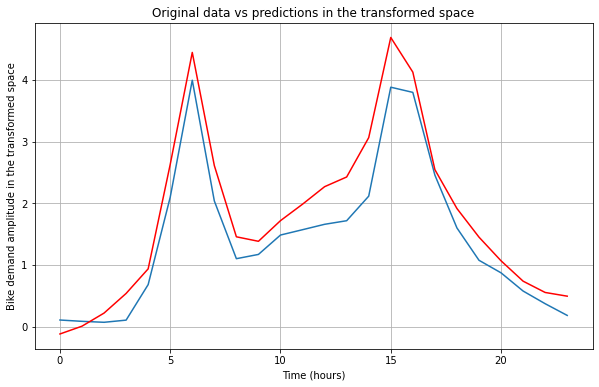

In [201]:
for i in range(0,24):
  the_hour = i
  y_pred_days = y_pred[the_hour,:]
  plt.figure(figsize=(10,6))
  plt.grid(True)
  plt.plot(y_test[the_hour,:],label='Orginal data - transformed')
  plt.plot(y_pred_days, color='red',label='Predictions - transformed')
  plt.xlabel('Time (hours)')
  plt.ylabel('Bike demand amplitude in the transformed space')
  plt.title('Original data vs predictions in the transformed space')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

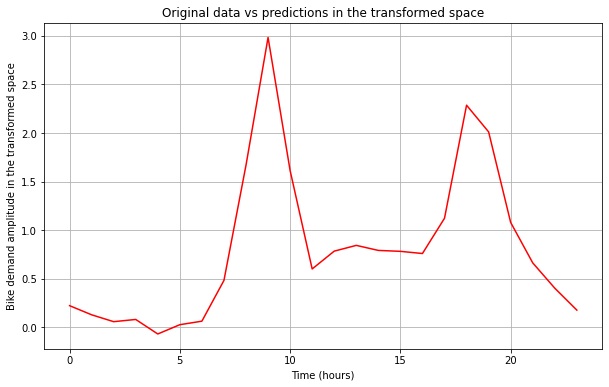

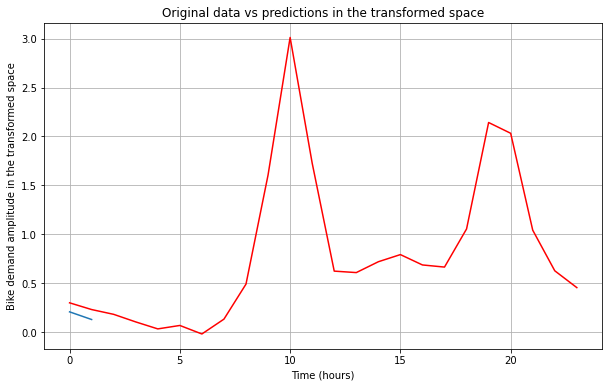

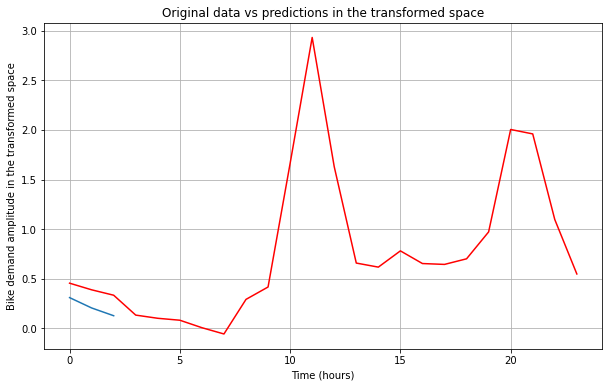

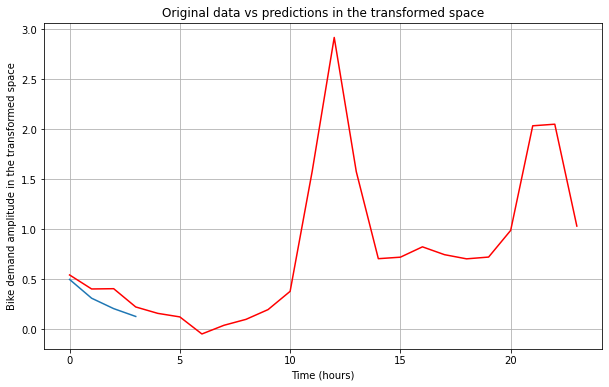

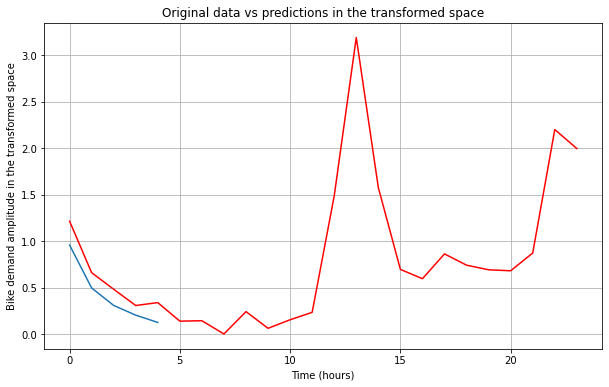

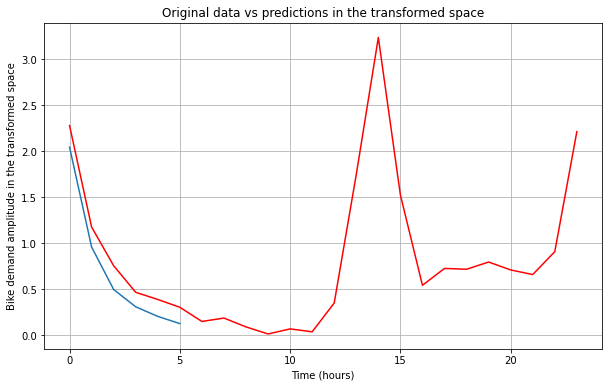

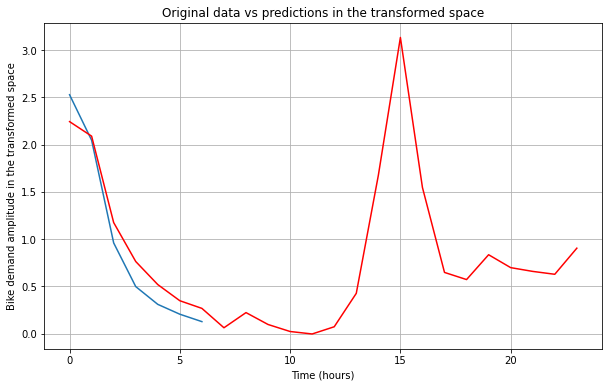

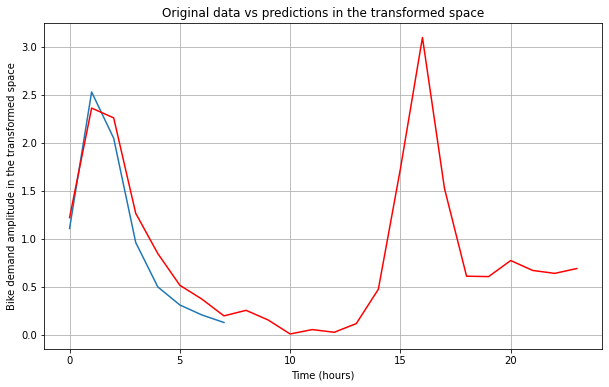

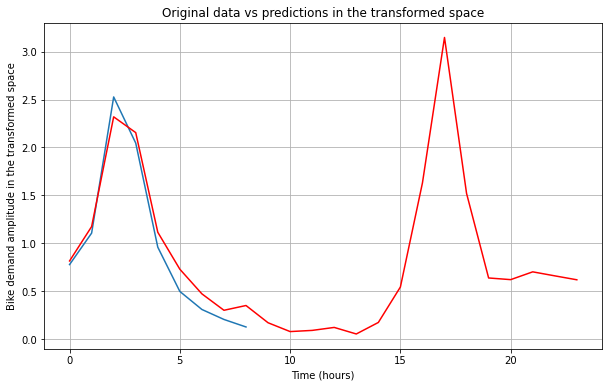

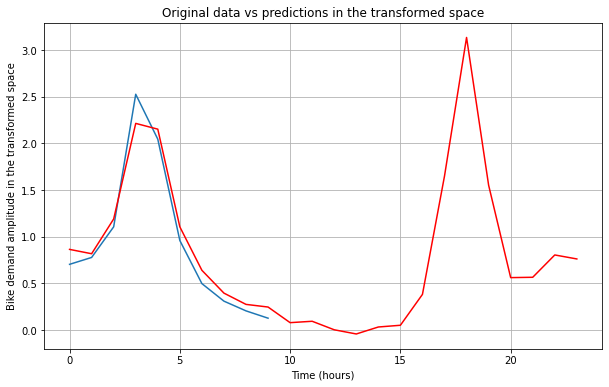

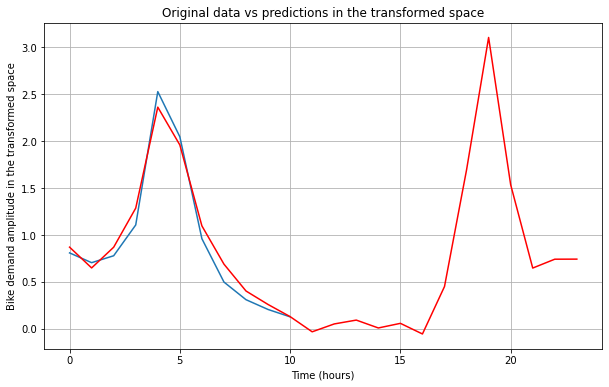

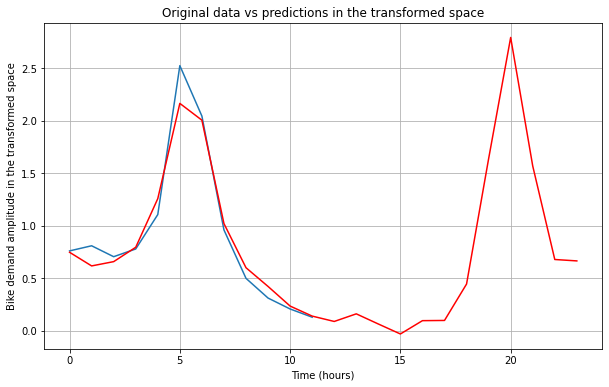

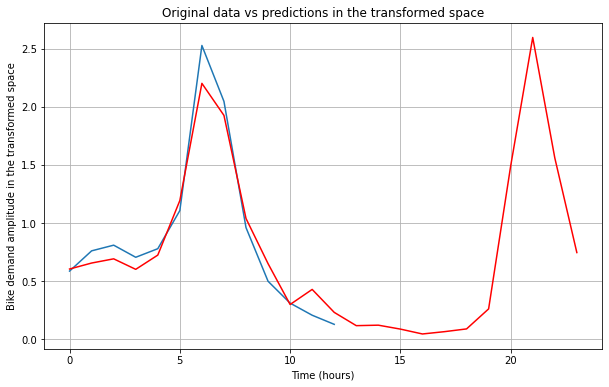

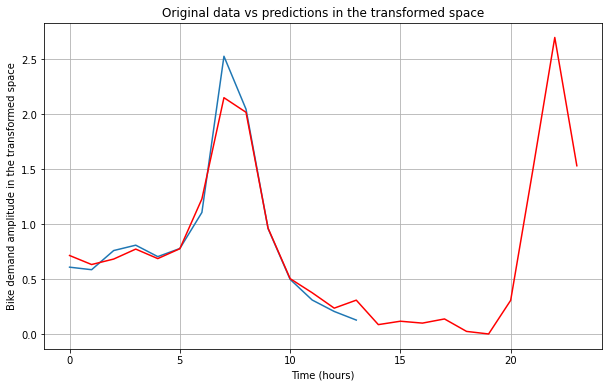

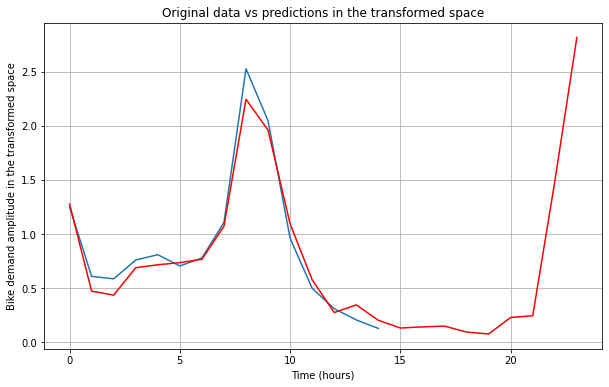

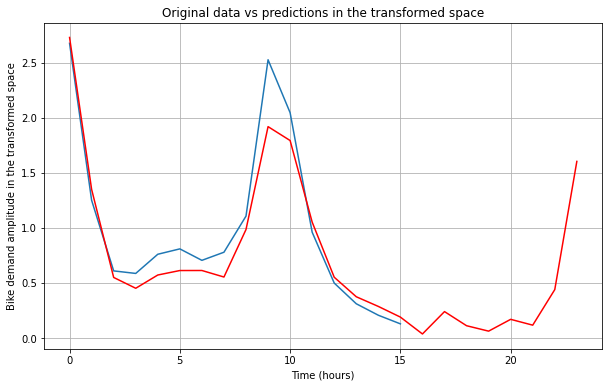

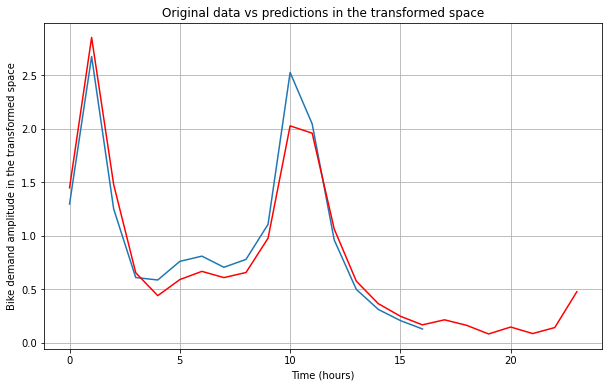

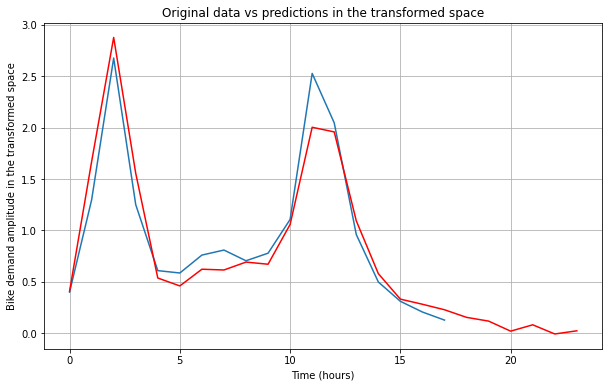

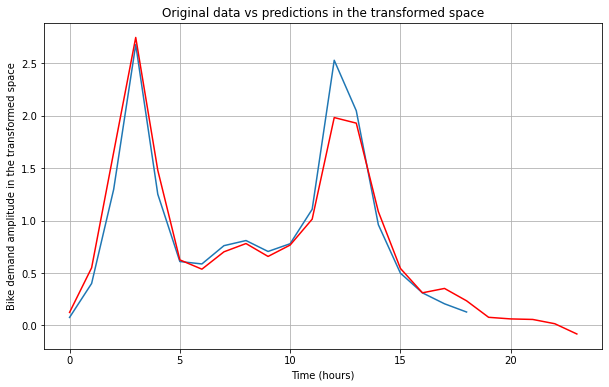

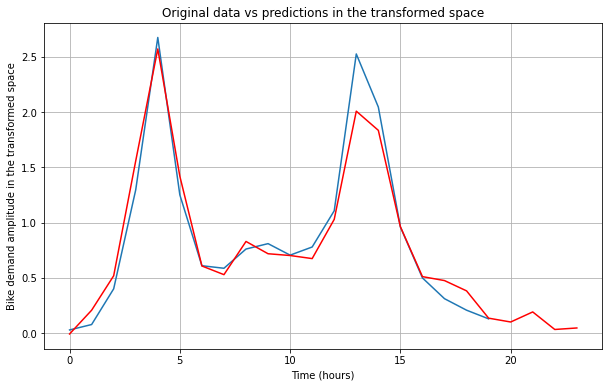

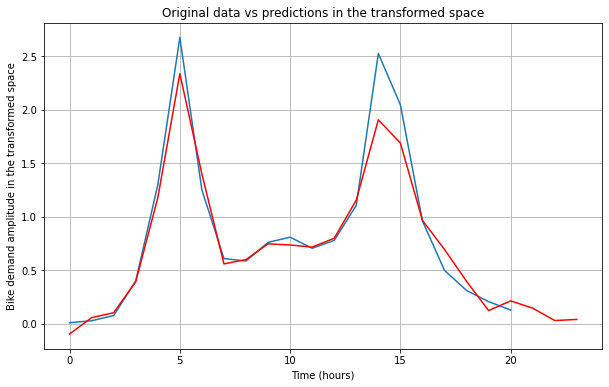

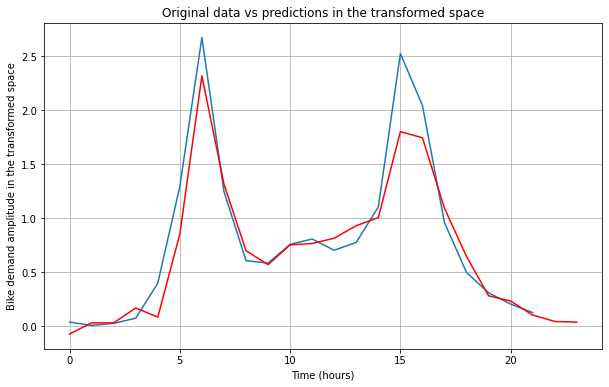

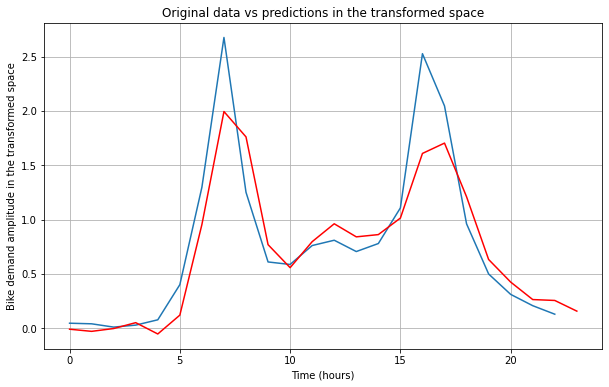

In [208]:
for i in range(1,24):
  the_hour = -i
  y_pred_days = y_pred[the_hour,:]
  plt.figure(figsize=(10,6))
  plt.grid(True)
  plt.plot(y_test[the_hour,:],label='Orginal data - transformed')
  plt.plot(y_pred_days, color='red',label='Predictions - transformed')
  plt.xlabel('Time (hours)')
  plt.ylabel('Bike demand amplitude in the transformed space')
  plt.title('Original data vs predictions in the transformed space')

Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

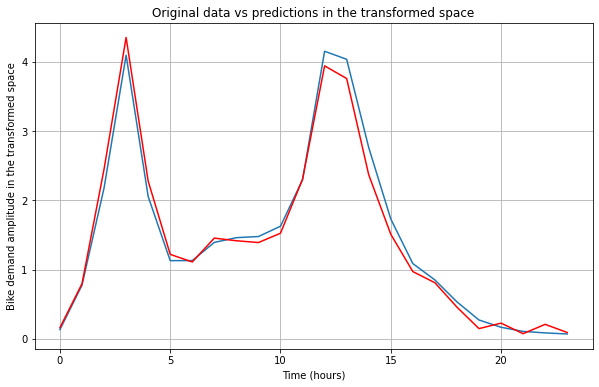

In [195]:
the_day = 2
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (hours)')
plt.ylabel('Bike demand amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

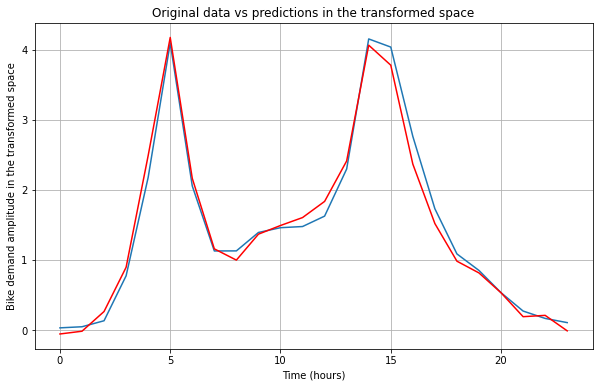

In [192]:
the_day = 0
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (hours)')
plt.ylabel('Bike demand amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

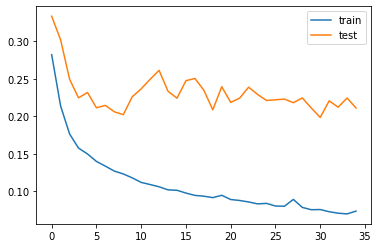

In [149]:
plt.plot(history_model_0.history['loss'], label='train')
plt.plot(history_model_0.history['val_loss'], label='test')
plt.legend();

In [203]:
# R2 scores y_pred
print("R2 del modelo en training      : ",
      R2_score(y_train, y_pred))

ValueError: ignored

Chequeo

In [171]:
y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

In [163]:
y_train_prediction.shape

(13883, 24)

In [179]:
target_train_pred = inverse_transform(y_train_prediction)
target_test_pred  = inverse_transform(y_test_prediction)

In [187]:
y_test_inv = inverse_transform(y_test)

In [180]:
target_train_pred.shape

(13883, 24)

In [181]:
y_train_prediction

array([[ 0.11859745,  0.12764654,  0.04211043, ...,  0.56862533,
         0.41495246,  0.29291603],
       [ 0.02799015,  0.0485474 ,  0.04224458, ...,  0.48202094,
         0.2922027 ,  0.19090441],
       [ 0.0343588 ,  0.04386388, -0.00711916, ...,  0.31824735,
         0.12140697,  0.11433038],
       ...,
       [ 0.1472924 ,  0.06550334,  0.11861002, ...,  0.80561507,
         0.70152545,  0.7037877 ],
       [-0.02739336, -0.00685152, -0.03452538, ...,  0.57948756,
         0.3002407 ,  0.2859222 ],
       [-0.15073834, -0.00273833,  0.04724509, ...,  0.449693  ,
         0.14806886,  0.15408781]], dtype=float32)

In [182]:
target_train_pred

array([[ 128.6901   ,  138.50925  ,   45.694023 , ...,  617.0153   ,
         450.2649   ,  317.84317  ],
       [  30.372108 ,   52.678783 ,   45.839596 , ...,  523.0409   ,
         317.06915  ,  207.15038  ],
       [  37.282734 ,   47.59669  ,   -7.7250047, ...,  345.3302   ,
         131.73871  ,  124.05989  ],
       ...,
       [ 159.82698  ,   71.077675 ,  128.70374  , ...,  874.1729   ,
         761.2252   ,  763.68     ],
       [ -29.72453  ,   -7.4345884,  -37.46349  , ...,  628.80194  ,
         325.79117  ,  310.25418  ],
       [-163.56618  ,   -2.9713583,   51.26564  , ...,  487.96185  ,
         160.66951  ,  167.20068  ]], dtype=float32)

In [ ]:
# Parece que me salen predicciones negativas y no pueden haberlas, como mucho tendríamos predicciones en 0 (días de tormenta)

In [184]:
resultsDict = {}

resultsDict['LSTM'] = evaluate(y_test_prediction, target_test_pred)
evaluate(y_test_prediction, target_test_pred)

NameError: ignored

Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

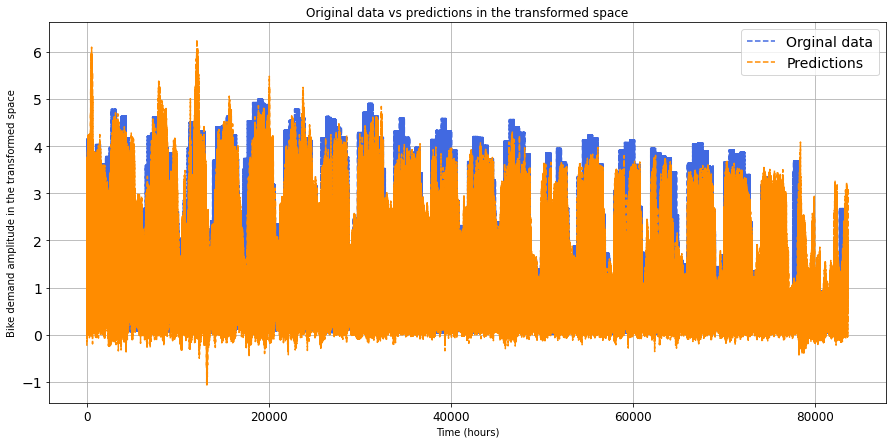

In [221]:
y_ = y_test.flatten()
y_pred_days_ = y_pred_days.flatten()

plt.figure(figsize=(15,7))
plt.grid(True)
plt.plot(y_test.flatten(),'--', c='royalblue', label='Orginal data')
plt.plot(y_test_prediction.flatten(), '--', c='darkorange', label='Predictions')
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
#plt.xlim([fechas_train[100],fechas_train[200]])
plt.legend(fontsize=14);

plt.xlabel('Time (hours)')
plt.ylabel('Bike demand amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')